In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from microphone import record_audio
from typing import Tuple
import librosa

# For peak finding:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.morphology import iterate_structure
from typing import Tuple, Callable, List

%matplotlib notebook

# Beginning of Task #2 as defined by Task Sheet:

Currently configured to take 5 seconds of audio from the microphone - Will be modified after testing to analyze existing recordings within a nearby folder

Using input device 'Internal Microphone (AMD Audio'
Recording ended


<IPython.core.display.Javascript object>


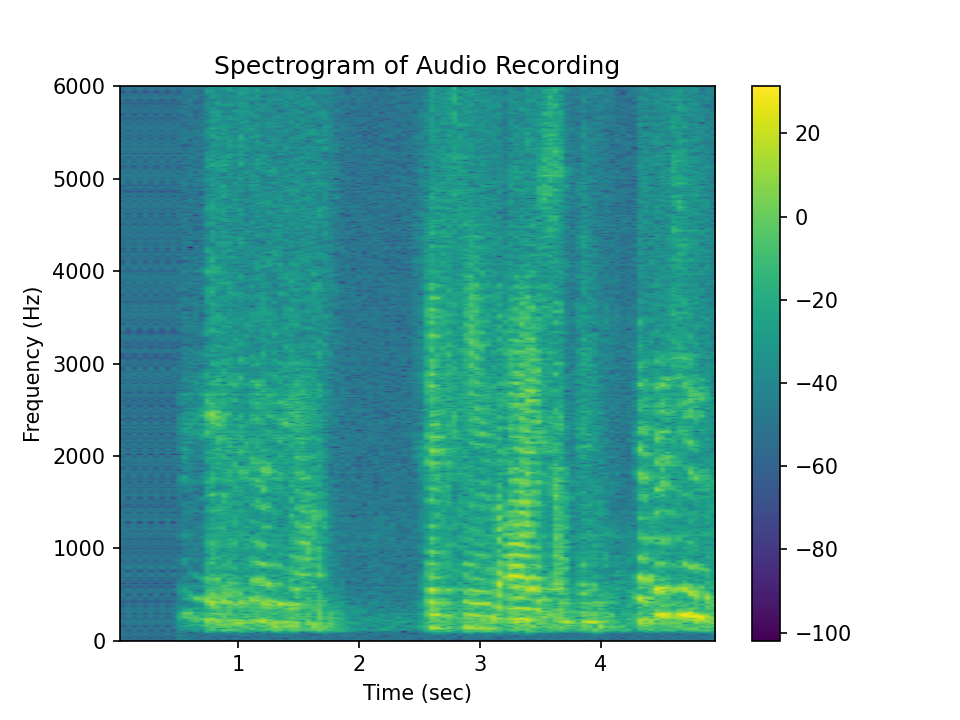

(0.0, 6000.0)

In [31]:
# This code block was used for testing, it records audio from mic for 5 seconds, and is not needed in final project. 
# Input array would be defined as 'S'.

frames, sample_rate = record_audio(5)
data = np.hstack([np.frombuffer(i, np.int16) for i in frames])

fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    data,
    NFFT=4096,
    Fs=sample_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Audio Recording")
ax.set_ylim(0, 6000)

In [32]:
from numba import njit

# `@njit` "decorates" the `_peaks` function. This tells Numba to
# compile this function using the "low level virtual machine" (LLVM)
# compiler. The resulting object is a Python function that, when called,
# executes optimized machine code instead of the Python code
# 
# The code used in _peaks adheres strictly to the subset of Python and
# NumPy that is supported by Numba's jit. This is a requirement in order
# for Numba to know how to compile this function to more efficient
# instructions for the machine to execute

@njit

def _peaks(
    data_2d: np.ndarray, rows: np.ndarray, cols: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    rows : numpy.ndarray, shape-(N,)
        The 0-centered row indices of the local neighborhood mask
    
    cols : numpy.ndarray, shape-(N,)
        The 0-centered column indices of the local neighborhood mask
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location. 
    """
    
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterate over the 2-D data in col-major order
    # we want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c)
        # dr: displacement from r
        # dc: discplacement from c
        for dr, dc in zip(rows, cols):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary
                continue

            # mirror over array boundary
            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a peak
            peaks.append((r, c))
    return peaks

# `local_peak_locations` is responsible for taking in the boolean mask `neighborhood`
# and converting it to a form that can be used by `_peaks`. This "outer" code is 
# not compatible with Numba which is why we end up using two functions:
# `local_peak_locations` does some initial pre-processing that is not compatible with
# Numba, and then it calls `_peaks` which contains all of the jit-compatible code
def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location.
    
    Notes
    -----
    Neighborhoods that overlap with the boundary are mirrored across the boundary.
    
    The local peaks are returned in column-major order.
    """
    
    rows, cols = np.where(neighborhood)
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    # center neighborhood indices around center of neighborhood
    rows -= neighborhood.shape[0] // 2
    cols -= neighborhood.shape[1] // 2

    return _peaks(data_2d, rows, cols, amp_min=amp_min)

In [33]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data.

    Parameters:
    data : numpy.ndarray, shape-(H, W)
    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""
    
    # Generate a rank-2, connectivity-2 binary mask
    r2c2 = generate_binary_structure(2, 2)


    # Use that neighborhood to find the local peaks in `data`.
    # Pass `cutoff` as `amp_min` to `local_peak_locations`.
    peak_locations = local_peak_locations(data, r2c2, cutoff)
    

    # Turns the list of (row, col) peak locations into a shape-(N_peak, 2) array
    # Save the result to the variable `peak_locations`
    peak_locations = np.array(peak_locations)

    # create a mask of zeros with the same shape as `data`
    mask = np.zeros(data.shape, dtype=bool)

    # populate the local peaks with `1`
    mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return mask

In [34]:
log_S = np.log(S).ravel()  # ravel flattens 2D spectrogram into a 1D array
ind = round(len(log_S) * 0.9)  # find the index associated with the 90th percentile log-amplitude
cutoff_log_amp = np.partition(log_S, ind)[ind]  # find the actual 90th percentile log-amplitude
cutoff_log_amp

-6.539048092675732

Thus $90\%$ of all of the Fourier coefficient amplitudes in this audio clip, $|a_{k}|$, fall beneath $e^{cutoff log amp}$.

In [36]:
peaks = local_peaks_mask(S, cutoff_log_amp)

# Task #8

In [55]:
#ex_dict = {song_id, ("song name", "artist")}
ex_dict = {1:("Little Wing", "Jimi Hendrix"), 2:("song2", "artist2")}
"""
Code would need to be added that grabs the dictionary with the actual songs used from the database.
That code is not currently here because that database does not exist as of the creation of this code.
ex_dict, as defined above, is used for testing purposes.
"""

def get_all(ex_dict):
    # ex_dict is the dictionary which stores a tuple of songs and artists as the value of keys which are ids.
    return [ex_dict[i] for i in range(1,len(ex_dict)+1)]
    # i refers to the id number, range begins at 1 and len is added by 1 because id begins (here at least) with 1, not 0. 

def get_song_names(ex_dict):
    return [ex_dict[i][0] for i in range(1, len(ex_dict)+1)]

def get_artists(ex_dict):
    return [ex_dict[i][1] for i in range(1, len(ex_dict)+1)]

print("Songs and Artists:", get_all(ex_dict))
print("Songs:            ", get_song_names(ex_dict))
print("Arists:           ", get_artists(ex_dict))

Songs and Artists: [('Little Wing', 'Jimi Hendrix'), ('song2', 'artist2')]
Songs:             ['Little Wing', 'song2']
Arists:            ['Jimi Hendrix', 'artist2']
